In [ ]:
!pip install torch torchvision Pillow scikit-learn --quiet

In [ ]:
import os, random, shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserhessein/the-vertebrae-xray-images")

print("Path to dataset files:", path)

100%|██████████| 81.8M/81.8M [00:05<00:00, 16.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yasserhessein/the-vertebrae-xray-images/versions/1


In [ ]:
# Пути и датасет
source_dir = "/root/.cache/kagglehub/datasets/yasserhessein/the-vertebrae-xray-images/versions/1/xkt857dsxk-1/299/299"

train_dir = "data/train"
val_dir   = "data/val"
test_dir  = "data/test"

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d + "/Normal", exist_ok=True)
    os.makedirs(d + "/Scol", exist_ok=True)

In [ ]:
# Разделение на train / val / test
for cls in ["Normal", "Scol"]:
    imgs = os.listdir(os.path.join(source_dir, cls))
    random.shuffle(imgs)
    n = len(imgs)
    train_split = int(0.7 * n)
    val_split   = int(0.15 * n)
    test_split  = n - train_split - val_split

    for i, img in enumerate(imgs):
        src = os.path.join(source_dir, cls, img)
        if i < train_split:
            dst_dir = os.path.join(train_dir, cls)
        elif i < train_split + val_split:
            dst_dir = os.path.join(val_dir, cls)
        else:
            dst_dir = os.path.join(test_dir, cls)
        shutil.copy(src, os.path.join(dst_dir, img))

print("Данные распределены по train / val / test")

Данные распределены по train / val / test


In [ ]:
# Трансформации
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data   = datasets.ImageFolder(val_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=16)
test_loader  = DataLoader(test_data, batch_size=16)

In [ ]:
# Модель Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 161MB/s]


In [ ]:
# Обучение и валидация
num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Валидация
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.3f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.3f}")

torch.save(model.state_dict(), "vit_scoliosis.pth")
print(" Обучение завершено и модель сохранена")

Epoch 1/5 | Train loss: 0.5202, acc: 0.772 | Val loss: 0.2158, acc: 0.842
Epoch 2/5 | Train loss: 0.1764, acc: 0.917 | Val loss: 0.1368, acc: 0.947
Epoch 3/5 | Train loss: 0.0162, acc: 1.000 | Val loss: 0.1487, acc: 0.947
Epoch 4/5 | Train loss: 0.0009, acc: 1.000 | Val loss: 0.1378, acc: 0.974
Epoch 5/5 | Train loss: 0.0003, acc: 1.000 | Val loss: 0.1514, acc: 0.974
 Обучение завершено и модель сохранена


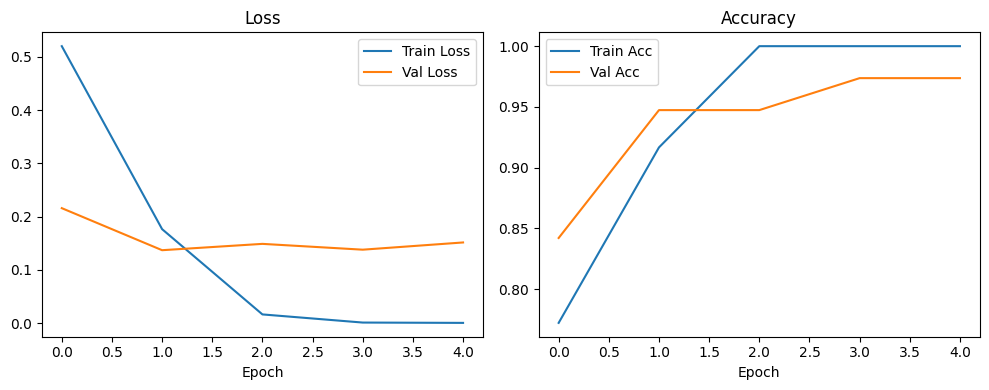

In [ ]:
#  Графики
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#  Тестирование
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(" Тестовые метрики ")
print(classification_report(all_labels, all_preds, target_names=test_data.classes))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)

 Тестовые метрики 
              precision    recall  f1-score   support

      Normal       1.00      0.83      0.91        12
        Scol       0.94      1.00      0.97        29

    accuracy                           0.95        41
   macro avg       0.97      0.92      0.94        41
weighted avg       0.95      0.95      0.95        41

Confusion matrix:
 [[10  2]
 [ 0 29]]


In [ ]:
import matplotlib.pyplot as plt

def predict(img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        pred = torch.argmax(out, 1).item()

    label = "Сколиоз" if pred == 1 else "Норма"

    #  Визуализация
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(f"Результат: {label}", fontsize=14)
    plt.axis("off")
    plt.show()


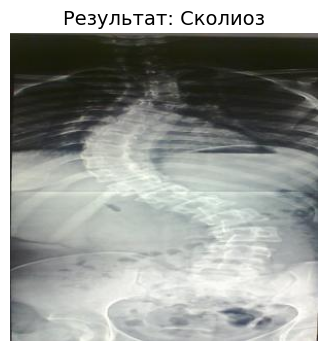

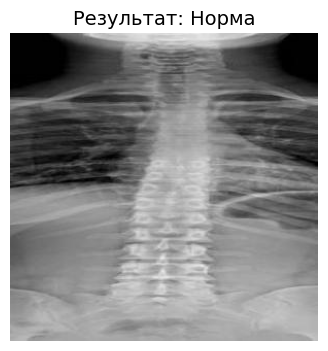

In [ ]:
#проверяем фото со сколиозом
predict("data/test/Scol/N120, Rt T and Lt L AIS, F, 15 yrs.jpg")

#проверяем фото без сколиоза
predict("data/test/Normal/N43,N,F,24_1_0.jpg")

